In [ ]:
!pip install umap-learn
!pip install --upgrade umap-learn

**Imports and global settings**

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

## EDA:

This dataset provides a comprehensive record of Apple Inc.'s stock price changes over the past 44 years. It includes essential columns such as the date, opening price, highest price of the day, lowest price of the day, closing price, adjusted closing price, and trading volume.

https://www.kaggle.com/datasets/mayankanand2701/apple-stock-price-dataset

**Reading in the dataset**

In [ ]:
# prompt: i have this ulr path to my csv https://drive.google.com/file/d/19VADLkrT6HD_98vlsar1y5s0OHZMCIBf/view?usp=drive_link,  how could i load it?

import pandas as pd

url = 'https://drive.google.com/file/d/19VADLkrT6HD_98vlsar1y5s0OHZMCIBf/view?usp=drive_link'

# Get the ID from the URL
file_id = url.split('/')[-2]

# Download the file from Google Drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='{file_id} -O apple_stock.csv

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('apple_stock.csv')
df.head()

--2024-06-20 13:22:46--  https://docs.google.com/uc?export=download&id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.101, 142.251.2.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf&export=download [following]
--2024-06-20 13:22:46--  https://drive.usercontent.google.com/download?id=19VADLkrT6HD_98vlsar1y5s0OHZMCIBf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743226 (726K) [application/octet-stream]
Saving to: ‘apple_stock.csv’

apple_stock.csv     100%[===================>] 725.81K  --.-KB/s    in 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10954 non-null  object 
 1   Open       10954 non-null  float64
 2   High       10954 non-null  float64
 3   Low        10954 non-null  float64
 4   Close      10954 non-null  float64
 5   Adj Close  10954 non-null  float64
 6   Volume     10954 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 599.2+ KB


In [91]:
def remove_random_rows(df, percentage):
    """
    Remove a percentage of rows randomly from the DataFrame.

    Parameters:
    df (pd.DataFrame): The original DataFrame.
    percentage (float): The percentage of rows to remove (between 0 and 100).

    Returns:
    pd.DataFrame: A new DataFrame with the specified percentage of rows removed.
    """
    # Calculate the fraction of rows to keep
    frac_to_keep = 1 - (percentage / 100.0)

    # Sample the DataFrame to keep the desired fraction of rows
    df_sampled = df.sample(frac=frac_to_keep, random_state=42)  # Use random_state for reproducibility

    return df_sampled

df = remove_random_rows(df, 95)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 5786 to 2405
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          27 non-null     float64
 1   high          27 non-null     float64
 2   low           27 non-null     float64
 3   close         27 non-null     float64
 4   adj close     27 non-null     float64
 5   volume        27 non-null     int64  
 6   date_numeric  27 non-null     int64  
dtypes: float64(5), int64(2)
memory usage: 1.7 KB


**Any duplicate rows?**

In [ ]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**Checking data types**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548 entries, 5412 to 10049
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       548 non-null    object 
 1   Open       548 non-null    float64
 2   High       548 non-null    float64
 3   Low        548 non-null    float64
 4   Close      548 non-null    float64
 5   Adj Close  548 non-null    float64
 6   Volume     548 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 34.2+ KB


In [ ]:
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = df['Date'].apply(lambda x: x.toordinal())

**Cleaning up column names (mainly for handling purposes)**

In [ ]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,date,open,high,low,close,adj close,volume,date_numeric
5412,2002-05-21,0.443393,0.446429,0.417857,0.418929,0.354185,280991200,730991
900,1984-07-05,0.112723,0.113839,0.108817,0.110491,0.085276,93184000,724462
2405,1990-06-19,0.348214,0.354911,0.342634,0.353795,0.281151,157225600,726637
2174,1989-07-20,0.363839,0.368304,0.354911,0.357143,0.280758,236073600,726303
7698,2011-06-17,11.749643,11.758929,11.405714,11.437857,9.670166,615020000,734305


**Quick overview over the individual distributions**

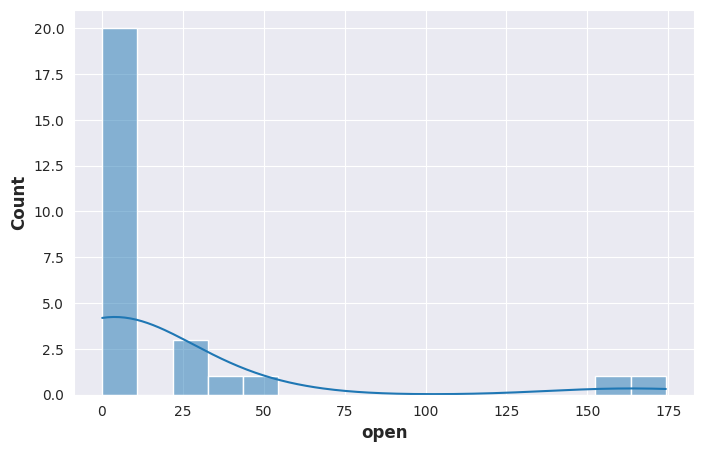

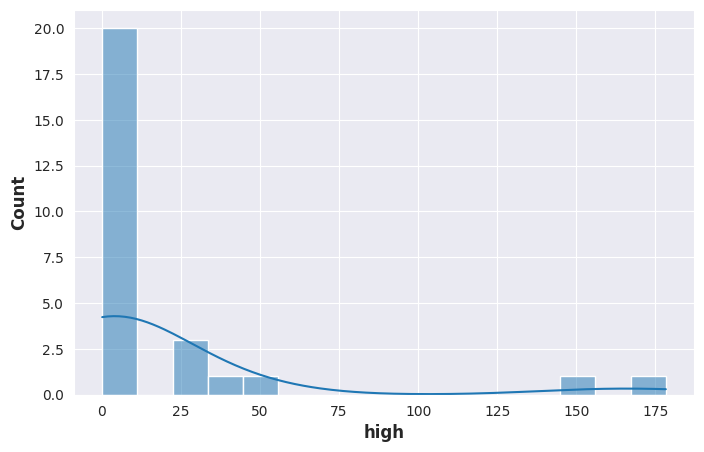

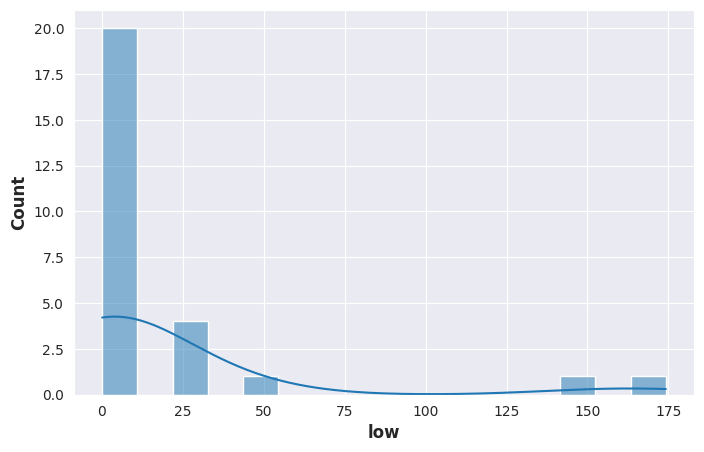

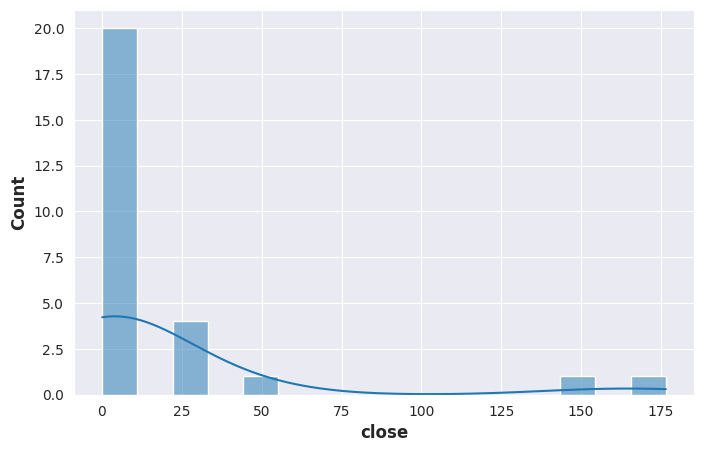

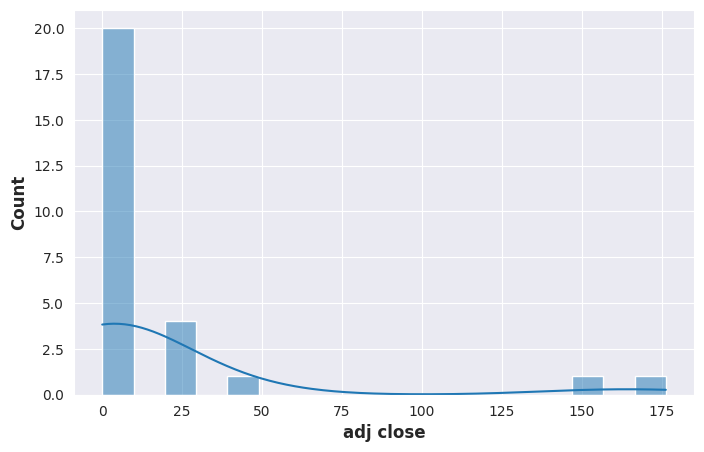

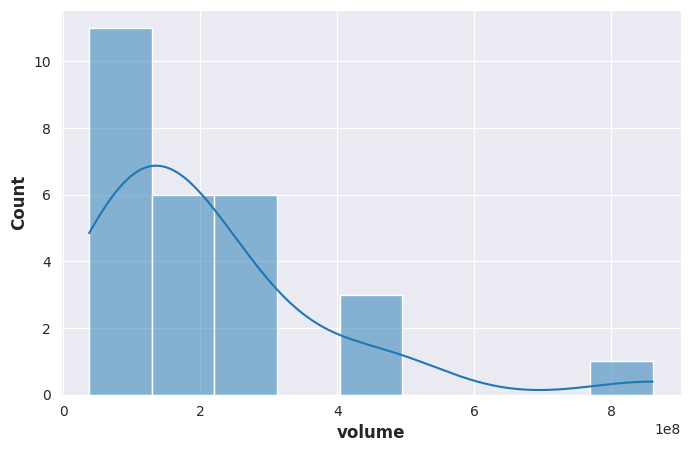

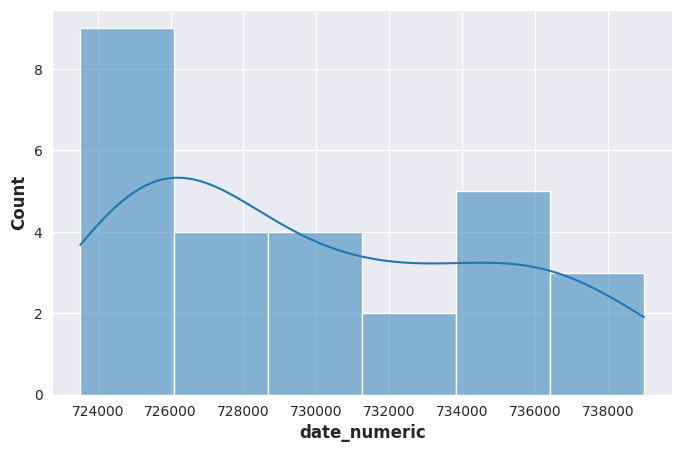

In [92]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

In [93]:
df = df.drop(columns=['date'])
df.head()

KeyError: "['date'] not found in axis"

# Clustering

In [ ]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [ ]:
X = StandardScaler().fit_transform(df)

In [ ]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,open,high,low,close,adj close,volume,date_numeric
0,-0.896697,-0.896986,-0.897390,-0.898340,-0.888501,-0.105599,0.005555
1,-0.920194,-0.920371,-0.919566,-0.920280,-0.908215,-1.046170,-1.493170
2,-0.903424,-0.903386,-0.902759,-0.902947,-0.893830,-0.659558,-0.981378
3,-0.902318,-0.902448,-0.901881,-0.902710,-0.893859,-0.278741,-1.059294
4,-0.284242,-0.288996,-0.293093,-0.296503,-0.348877,0.558357,0.712278


## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 7 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

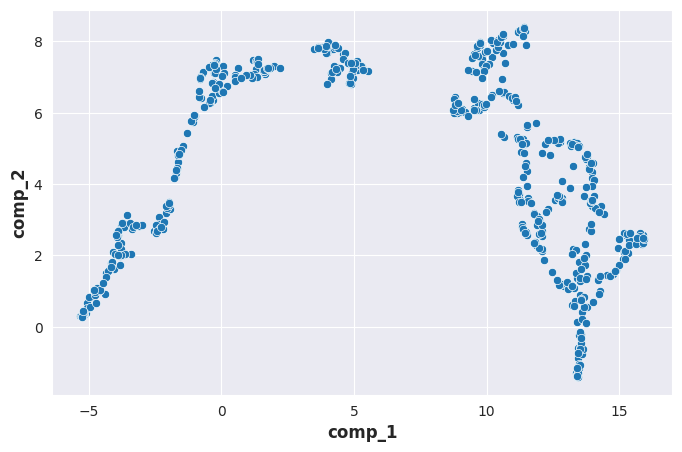

In [ ]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [ ]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [ ]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [ ]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

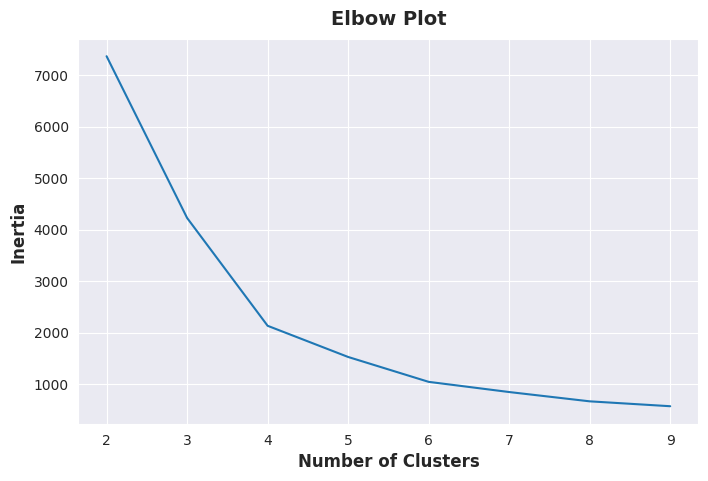

In [ ]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> Salient "kink" at 3 clusters. This is thus the number of clusters to go for. As discussed above, this is along the lines of what is to be expected by just looking at the data. [3, 5] clusters

### Run with optimised *n_clusters*

3 clusters

In [ ]:
%%time

clusters = 4
start_time = time.time()

kmeans = KMeans(n_clusters=clusters, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 5, max_iter: 300

CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 24.8 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


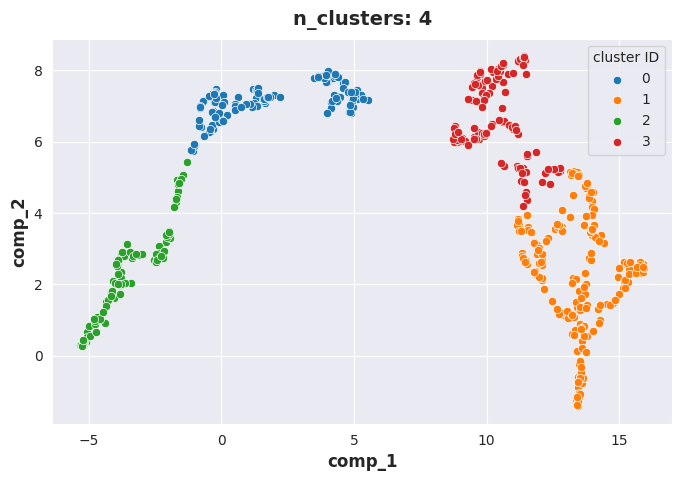

In [ ]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=clusters, noise_exist=False)


## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [ ]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 14, max_iter: 300

CPU times: user 535 ms, sys: 137 ms, total: 672 ms
Wall time: 4.38 s


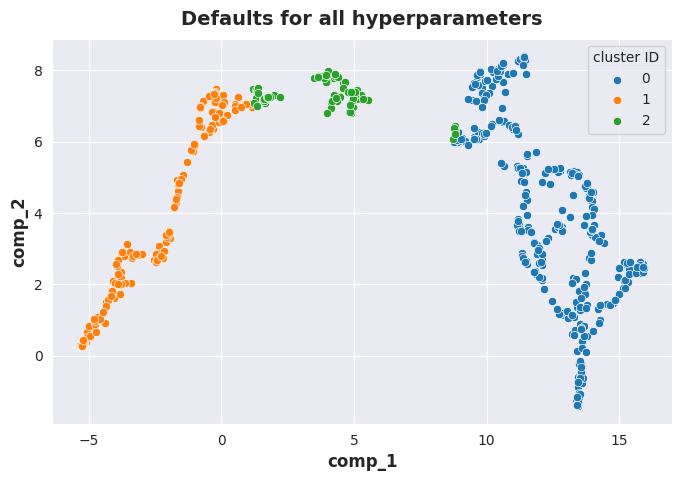

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 14, max_iter: 300

CPU times: user 241 ms, sys: 23.5 ms, total: 265 ms
Wall time: 2.05 s


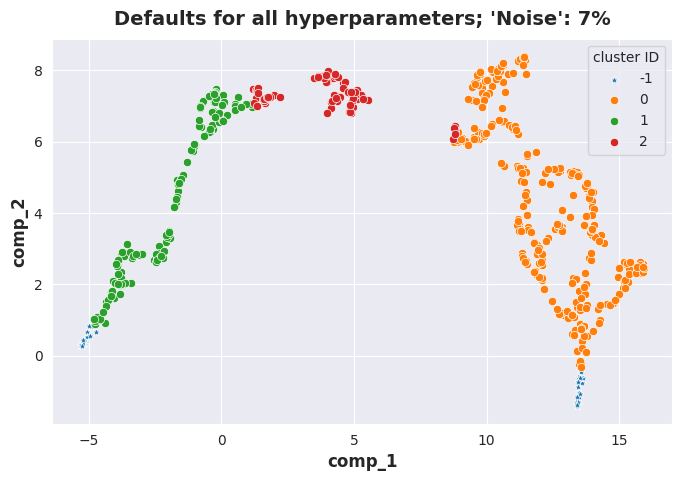

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 7%.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [ ]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [ ]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 16, max_iter: 100

CPU times: user 125 ms, sys: 16.4 ms, total: 141 ms
Wall time: 232 ms


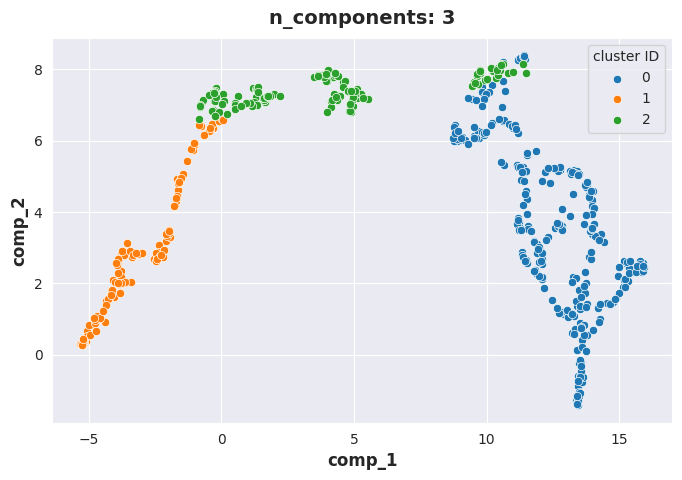

In [ ]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [ ]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)


CPU times: user 1.07 s, sys: 51.2 ms, total: 1.12 s
Wall time: 1.2 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


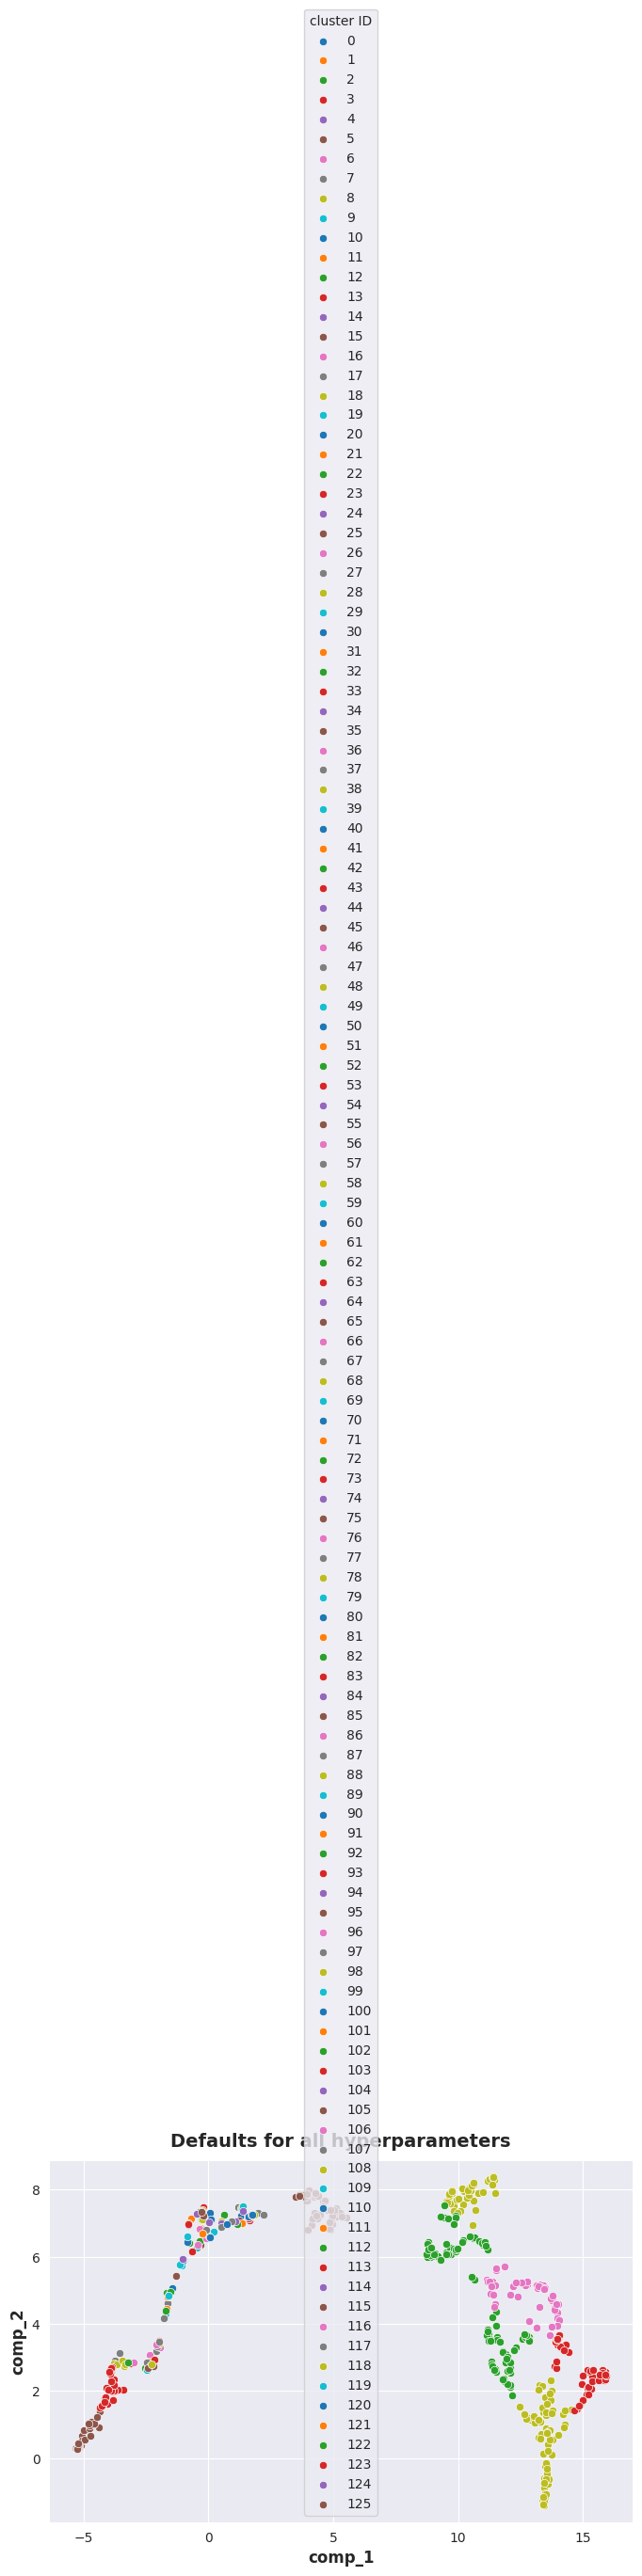

In [ ]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


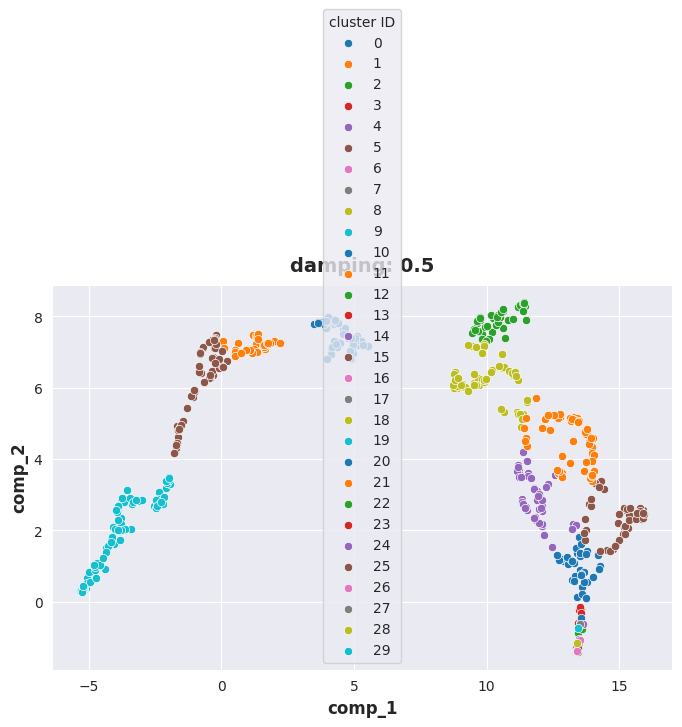

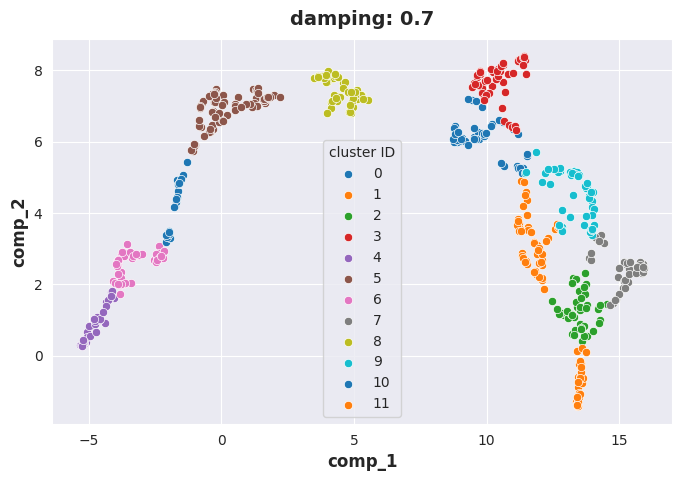

Algorithm converged successfully!
n_iter: 35, max_iter: 500



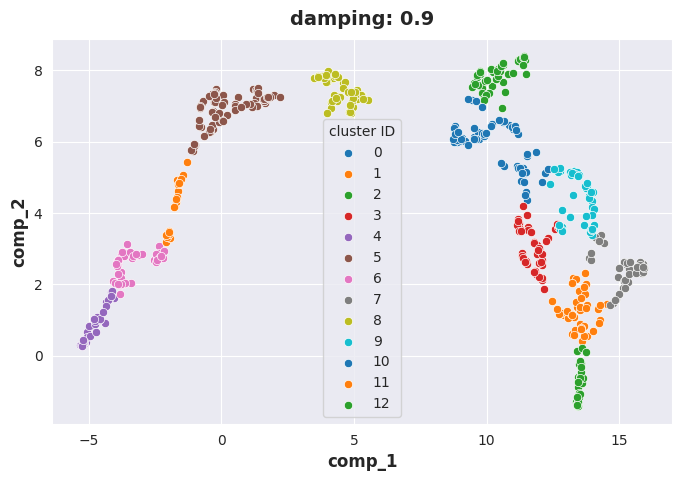

Algorithm converged successfully!
n_iter: 54, max_iter: 500



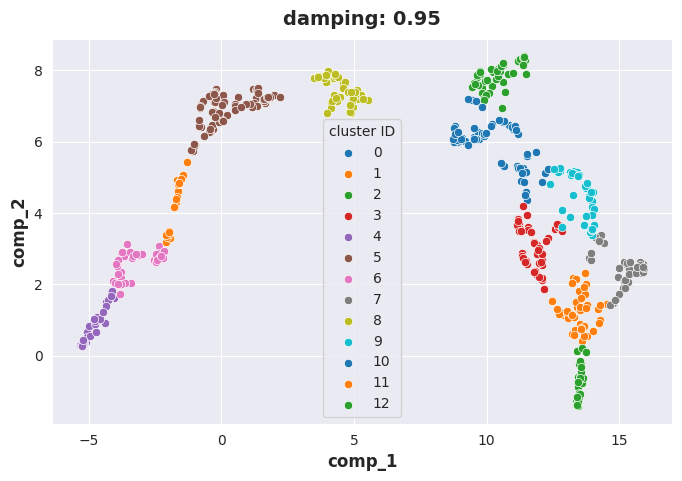

Algorithm converged successfully!
n_iter: 96, max_iter: 500



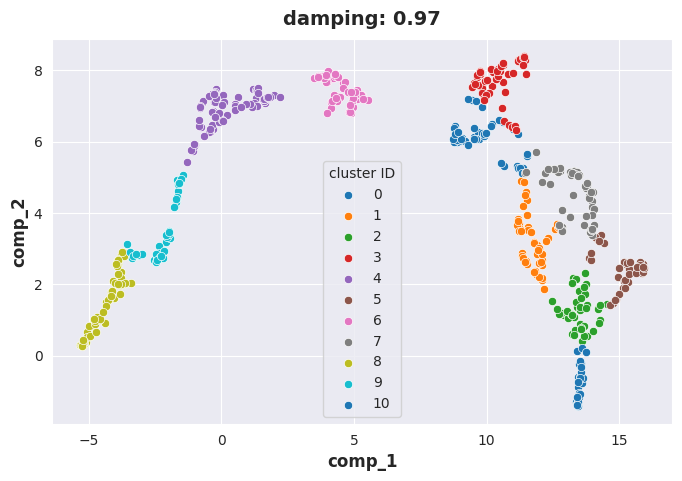

Algorithm converged successfully!
n_iter: 133, max_iter: 500



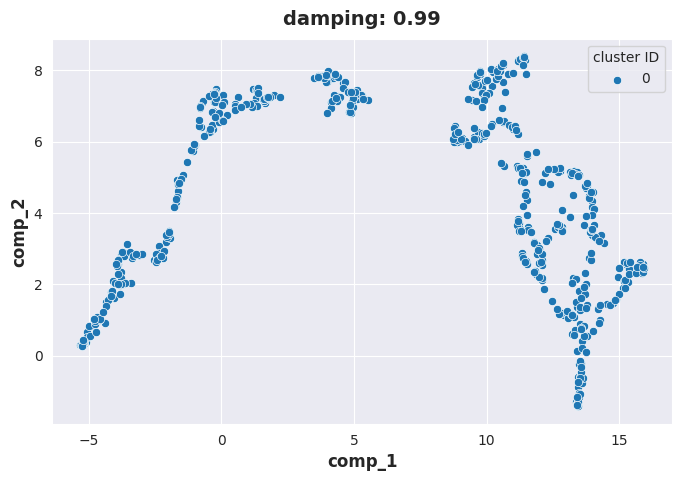

Algorithm converged successfully!
n_iter: 275, max_iter: 500

CPU times: user 13 s, sys: 955 ms, total: 13.9 s
Wall time: 18.9 s


In [ ]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [ ]:
# hyperparamter to tune

affprop_hparam = "preference"

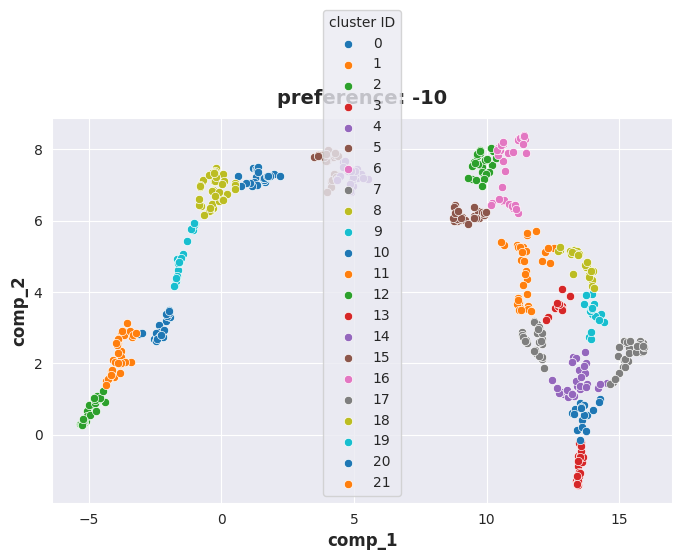

Algorithm converged successfully!
n_iter: 48, max_iter: 500



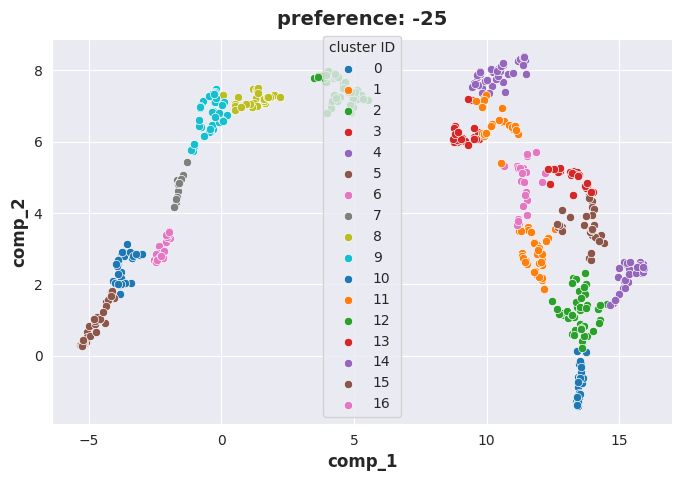

Algorithm converged successfully!
n_iter: 73, max_iter: 500



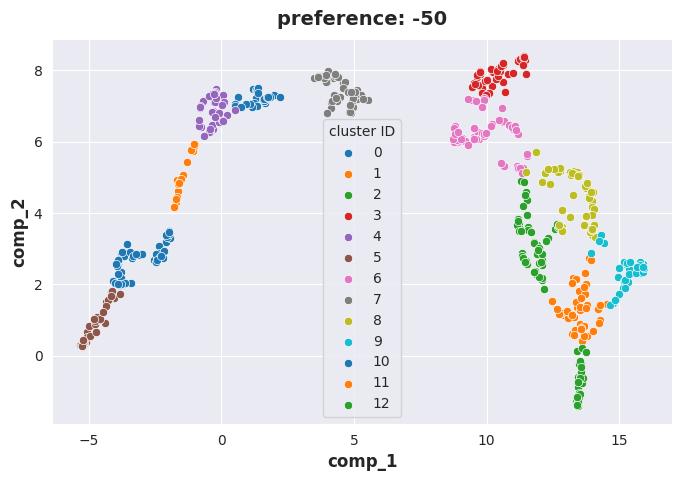

Algorithm converged successfully!
n_iter: 228, max_iter: 500



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


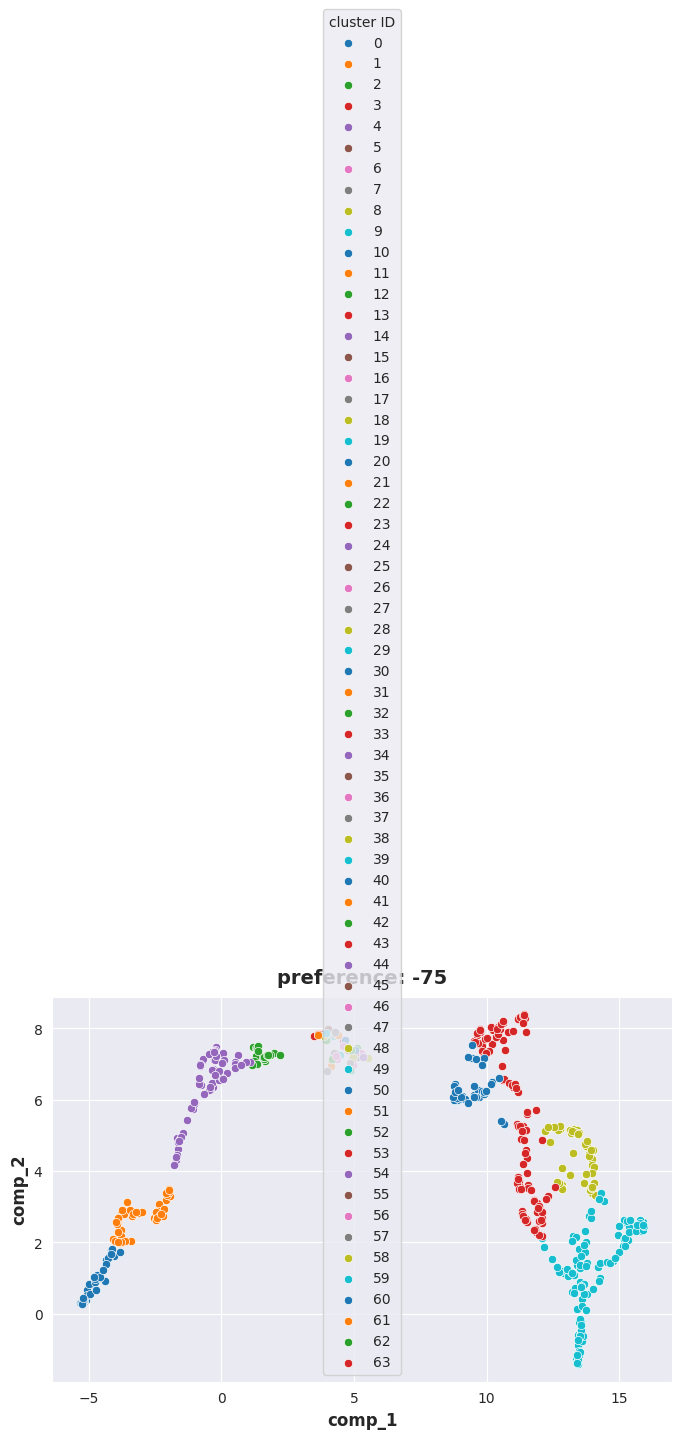

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


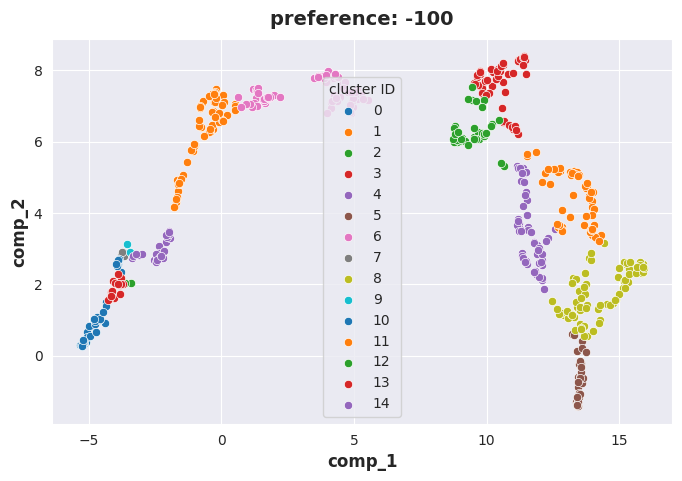


CPU times: user 17 s, sys: 925 ms, total: 17.9 s
Wall time: 18.8 s


In [ ]:
### Too much time calculating

%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

### Re-run with optimised *preference*

In [ ]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)


CPU times: user 2.51 s, sys: 55.1 ms, total: 2.56 s
Wall time: 3.33 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [ ]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

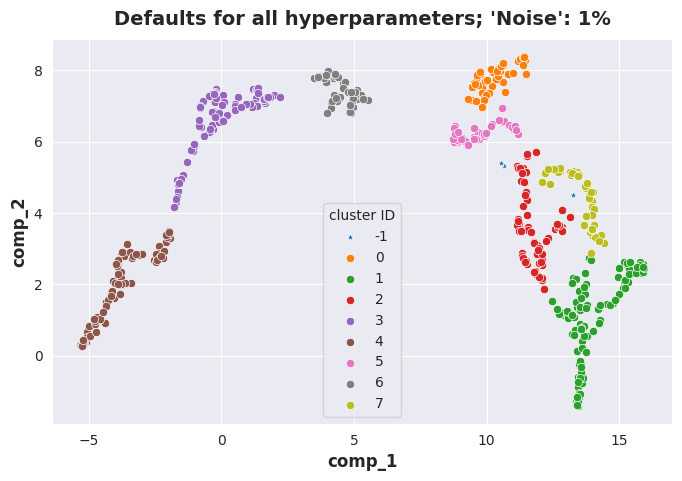

CPU times: user 728 ms, sys: 111 ms, total: 839 ms
Wall time: 730 ms


In [ ]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 1%, meaning?

### Tuning runs for *eps*

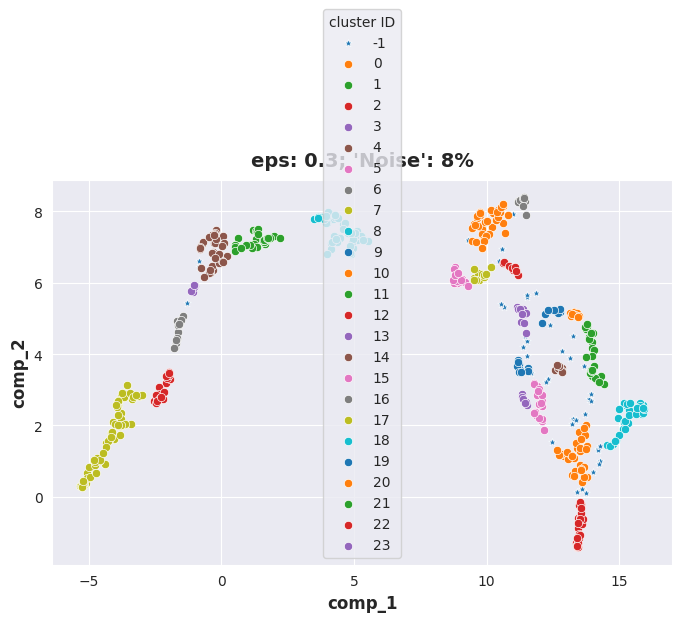

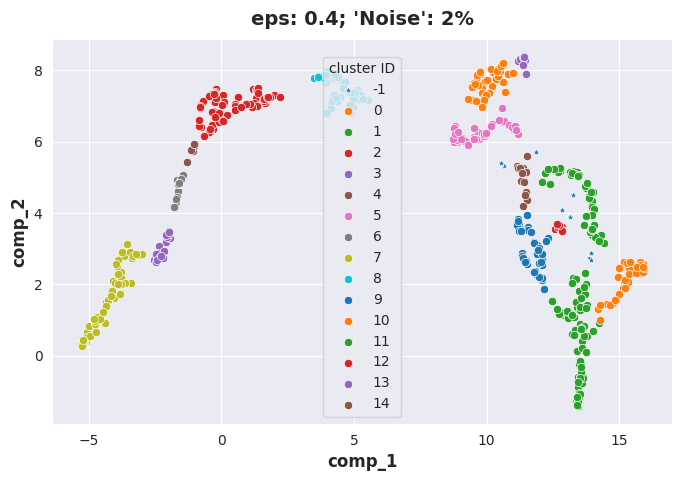

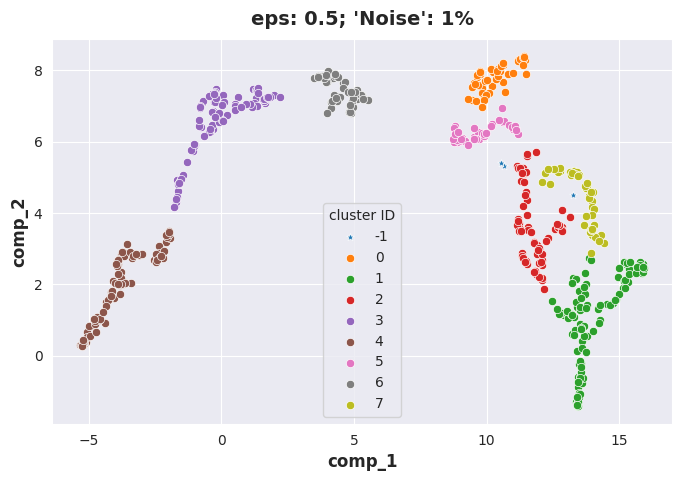

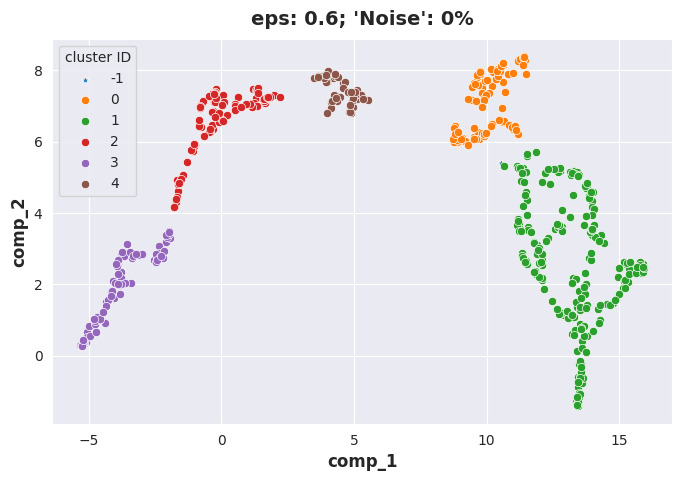

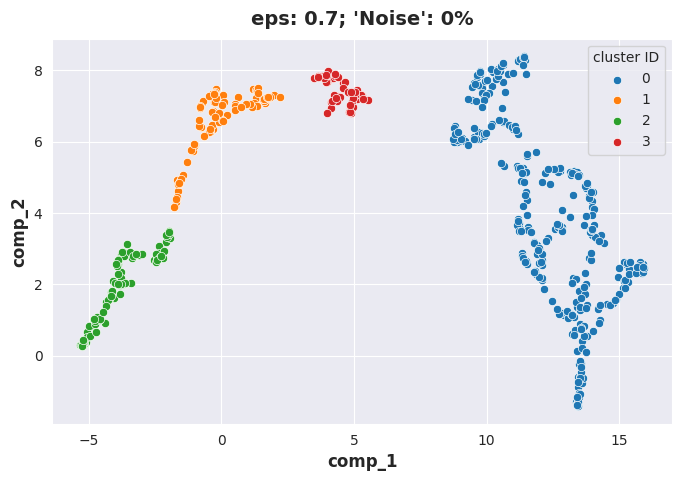

CPU times: user 6.28 s, sys: 370 ms, total: 6.65 s
Wall time: 8.6 s


In [ ]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

Seems 0.5 is the best

### Re-run with optimised *eps*

In [ ]:
%%time

eps_val = 0.7

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)


CPU times: user 11.1 ms, sys: 2.94 ms, total: 14.1 ms
Wall time: 24.8 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [ ]:
# hyperparamter to tune

optics_hparam = "min_samples"

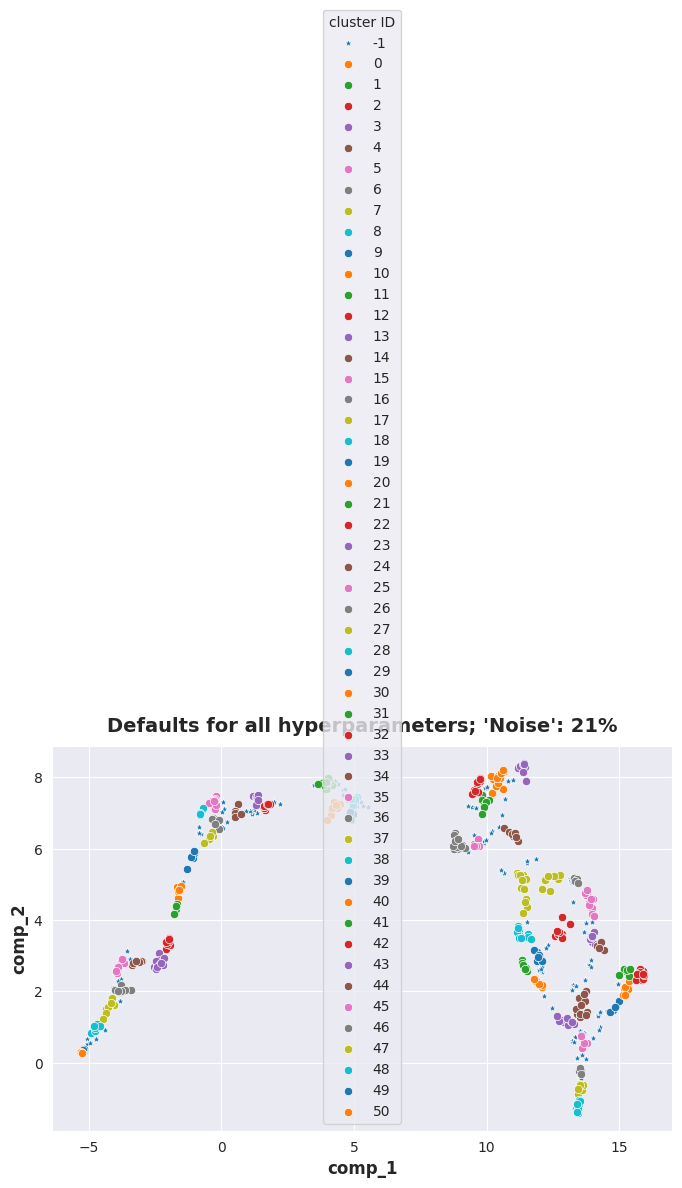

CPU times: user 7.37 s, sys: 593 ms, total: 7.96 s
Wall time: 13.9 s


In [ ]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

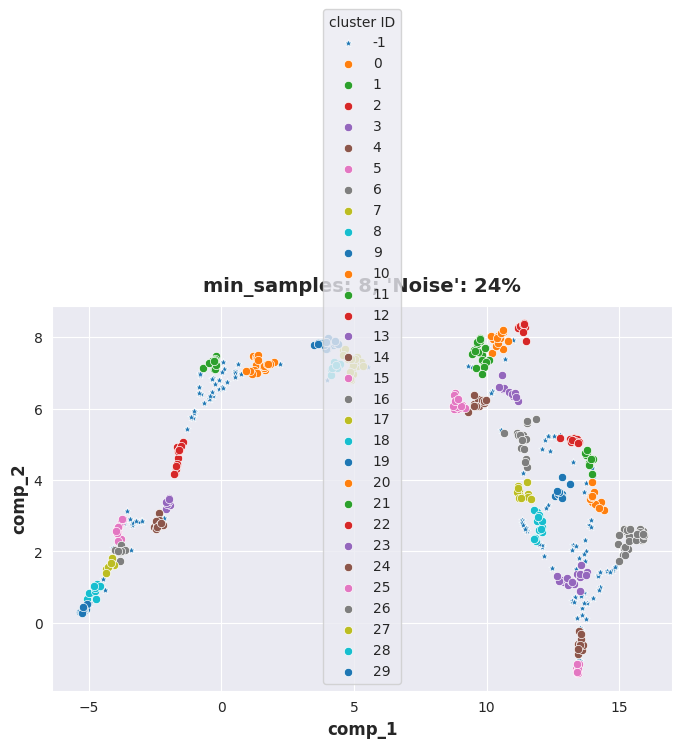

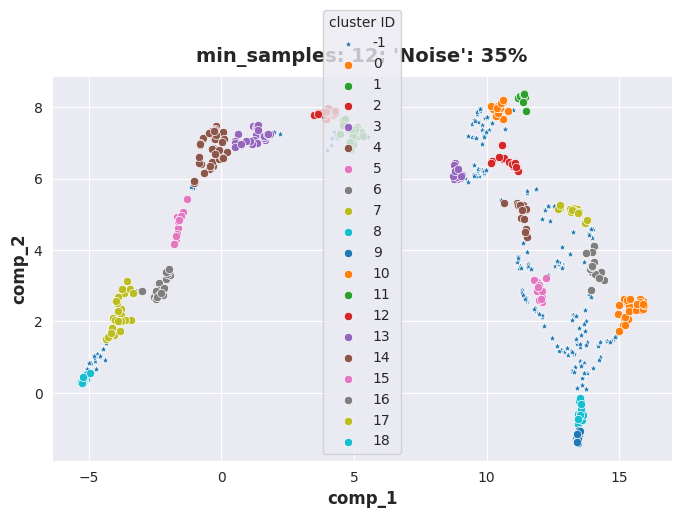

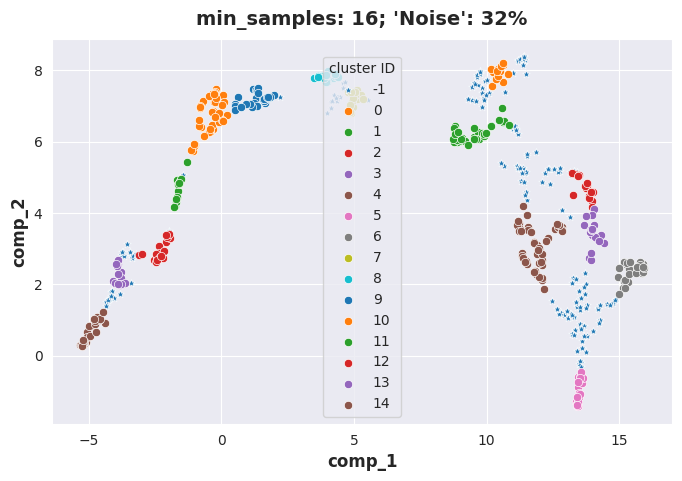

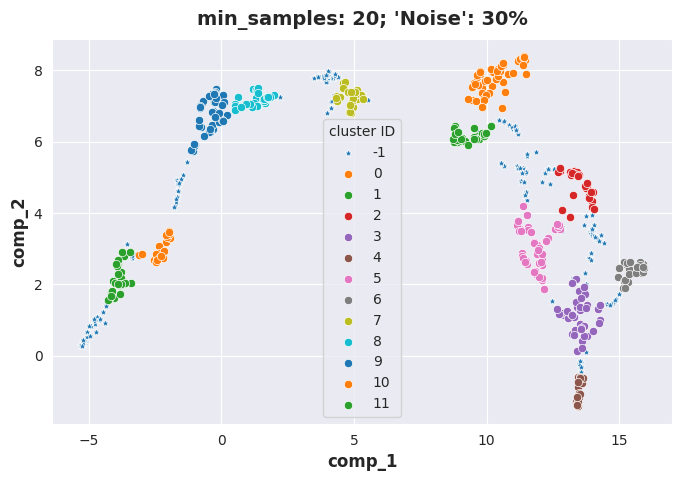

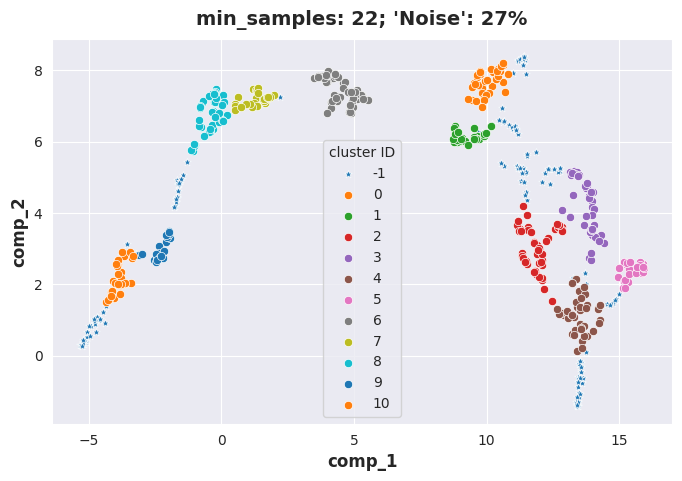

CPU times: user 15.7 s, sys: 3.07 s, total: 18.8 s
Wall time: 46.7 s


In [ ]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

In [ ]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 2.17 s, sys: 499 ms, total: 2.67 s
Wall time: 11.5 s


[0.0247647762298584, 4.376559734344482, 0.23185372352600098, 3.33410382270813, 0.024740219116210938, 11.525014162063599]


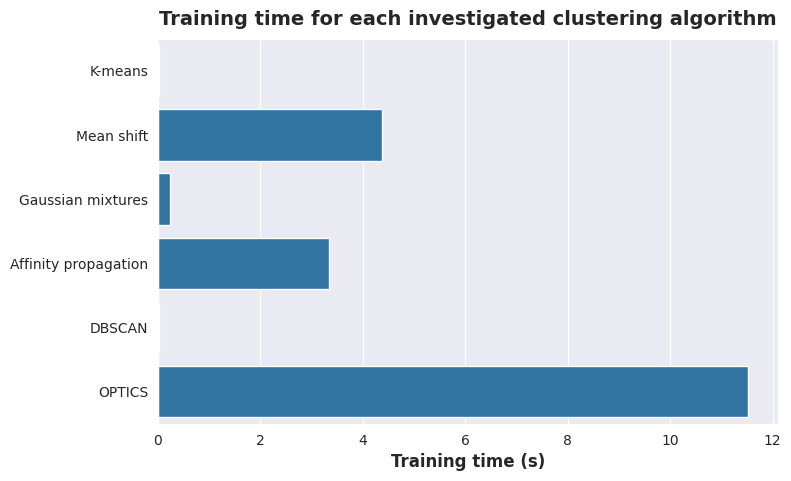

In [ ]:
print(training_times)
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [ ]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

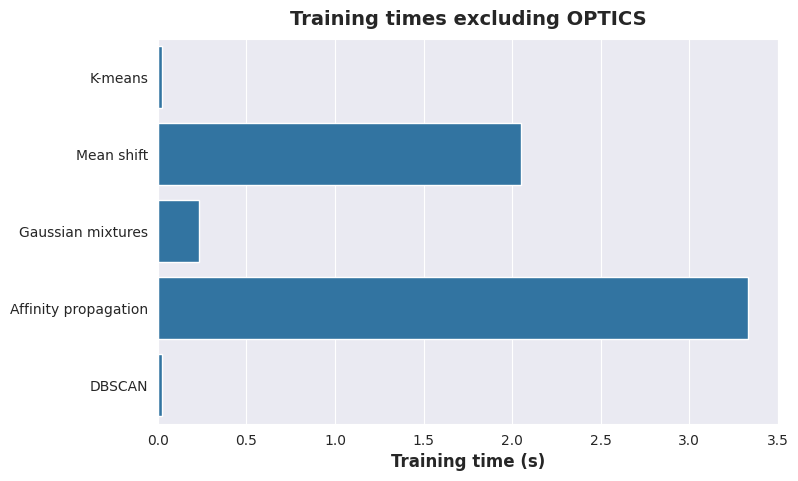

In [ ]:
# overwriting the training time for Mean shift

plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()